# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from asgn2.classifiers.fc_net import *
from asgn2.data_utils import get_CIFAR10_data
from asgn2.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from asgn2.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


# Dropout forward pass
In the file `asgn2/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [3]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print 'Running tests with p = ', p
  print 'Mean of input: ', x.mean()
  print 'Mean of train-time output: ', out.mean()
  print 'Mean of test-time output: ', out_test.mean()
  print 'Fraction of train-time output set to zero: ', (out == 0).mean()
  print 'Fraction of test-time output set to zero: ', (out_test == 0).mean()
  print

Running tests with p =  0.3
Mean of input:  10.0397150062
Mean of train-time output:  10.0397150062
Mean of test-time output:  10.0397150062
Fraction of train-time output set to zero:  0.698748
Fraction of test-time output set to zero:  0.698748

Running tests with p =  0.6
Mean of input:  10.0436977579
Mean of train-time output:  10.0436977579
Mean of test-time output:  10.0436977579
Fraction of train-time output set to zero:  0.81914
Fraction of test-time output set to zero:  0.81914

Running tests with p =  0.75
Mean of input:  10.0516361976
Mean of train-time output:  10.0516361976
Mean of test-time output:  10.0516361976
Fraction of train-time output set to zero:  0.864244
Fraction of test-time output set to zero:  0.864244



# Dropout backward pass
In the file `asgn2/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [4]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print 'dx relative error: ', rel_error(dx, dx_num)

dx relative error:  1.0


# Fully-connected nets with Dropout
In the file `asgn2/classifiers/fc_net.py`, modify your implementation to use dropout. Specificially, if the constructor the the net receives a nonzero value for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [5]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print 'Running check with dropout = ', dropout
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print 'Initial loss: ', loss

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))
  print

Running check with dropout =  0
Initial loss:  2.3051948274
W1 relative error: 2.53e-07
W2 relative error: 1.50e-05
W3 relative error: 2.75e-07
b1 relative error: 2.94e-06
b2 relative error: 5.05e-08
b3 relative error: 1.17e-10

Running check with dropout =  0.25
Initial loss:  2.31264683457
W1 relative error: 1.48e-08
W2 relative error: 2.34e-10
W3 relative error: 3.56e-08
b1 relative error: 1.53e-09
b2 relative error: 1.84e-10
b3 relative error: 8.70e-11

Running check with dropout =  0.5
Initial loss:  2.30243758771
W1 relative error: 4.55e-08
W2 relative error: 2.97e-08
W3 relative error: 4.34e-07
b1 relative error: 1.87e-08
b2 relative error: 5.05e-09
b3 relative error: 7.49e-11



# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a dropout probability of 0.75. We will then visualize the training and validation accuracies of the two networks over time.

In [6]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print dropout

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

0
(Iteration 1 / 125) loss: 8.596245
(Epoch 0 / 25) train acc: 0.218000; val_acc: 0.176000
(Epoch 1 / 25) train acc: 0.412000; val_acc: 0.229000
(Epoch 2 / 25) train acc: 0.496000; val_acc: 0.251000
(Epoch 3 / 25) train acc: 0.594000; val_acc: 0.269000
(Epoch 4 / 25) train acc: 0.648000; val_acc: 0.252000
(Epoch 5 / 25) train acc: 0.742000; val_acc: 0.267000
(Epoch 6 / 25) train acc: 0.812000; val_acc: 0.295000
(Epoch 7 / 25) train acc: 0.854000; val_acc: 0.290000
(Epoch 8 / 25) train acc: 0.888000; val_acc: 0.286000
(Epoch 9 / 25) train acc: 0.940000; val_acc: 0.294000
(Epoch 10 / 25) train acc: 0.948000; val_acc: 0.300000
(Epoch 11 / 25) train acc: 0.936000; val_acc: 0.272000
(Epoch 12 / 25) train acc: 0.972000; val_acc: 0.293000
(Epoch 13 / 25) train acc: 0.958000; val_acc: 0.296000
(Epoch 14 / 25) train acc: 0.968000; val_acc: 0.285000
(Epoch 15 / 25) train acc: 0.956000; val_acc: 0.299000
(Epoch 16 / 25) train acc: 0.984000; val_acc: 0.298000
(Epoch 17 / 25) train acc: 0.968000; v

asgn2/layers.py:738: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N


(Epoch 2 / 25) train acc: 0.502000; val_acc: 0.274000
(Epoch 3 / 25) train acc: 0.568000; val_acc: 0.265000
(Epoch 4 / 25) train acc: 0.644000; val_acc: 0.298000
(Epoch 5 / 25) train acc: 0.710000; val_acc: 0.276000
(Epoch 6 / 25) train acc: 0.766000; val_acc: 0.289000
(Epoch 7 / 25) train acc: 0.814000; val_acc: 0.277000
(Epoch 8 / 25) train acc: 0.818000; val_acc: 0.263000
(Epoch 9 / 25) train acc: 0.884000; val_acc: 0.277000
(Epoch 10 / 25) train acc: 0.906000; val_acc: 0.269000
(Epoch 11 / 25) train acc: 0.944000; val_acc: 0.287000
(Epoch 12 / 25) train acc: 0.924000; val_acc: 0.313000
(Epoch 13 / 25) train acc: 0.934000; val_acc: 0.283000
(Epoch 14 / 25) train acc: 0.948000; val_acc: 0.307000
(Epoch 15 / 25) train acc: 0.968000; val_acc: 0.333000
(Epoch 16 / 25) train acc: 0.976000; val_acc: 0.326000
(Epoch 17 / 25) train acc: 0.978000; val_acc: 0.313000
(Epoch 18 / 25) train acc: 0.968000; val_acc: 0.313000
(Epoch 19 / 25) train acc: 0.988000; val_acc: 0.324000
(Epoch 20 / 25) tr

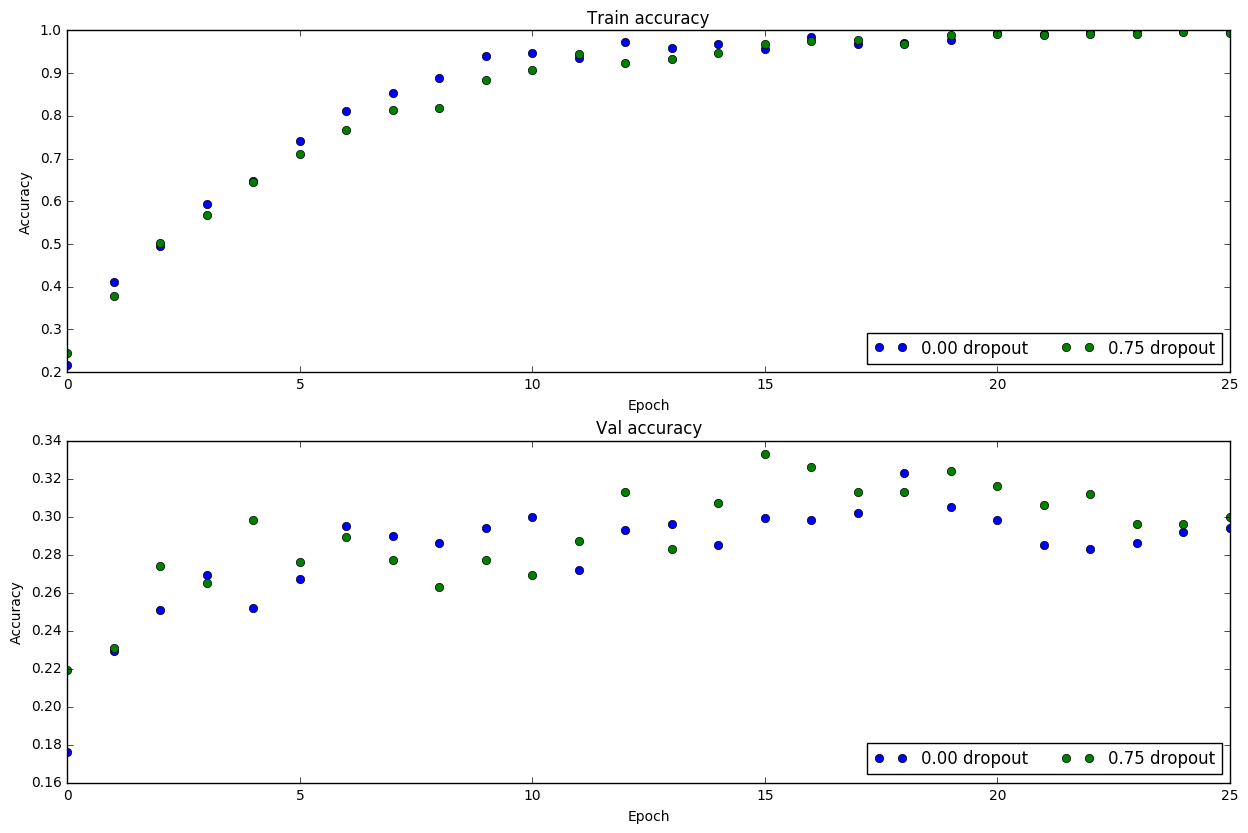

In [7]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Question
Explain what you see in this experiment. What does it suggest about dropout?

# Answer

Since both the networks had zero regularization, they overfit the data. However, the network with dropout is able to control this overfitting to higher degree. This experiment shows that dropout acts as a regularizer(as the validation curve from dropout network is slightly above the other network's curve), however, it seems more efficient to couple dropout with a standard regularization term like L2 loss.